In [2]:
###  RUN FROM SCRATCH  ### 

import argparse
import collections
from pathlib import Path
import csv
import os 

import numpy as np 

import torch
import torch.optim as optim
from torchvision import transforms, utils as vision_utils 
#from torch.utils.tensorboard import SummaryWriter

from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer, BalancedSampler
from torch.utils.data import DataLoader

from retinanet.sampler import SamplerFactory, aggregate_indices_per_class 


from retinanet import coco_eval
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'


MODELS_DIR = '/home/ubuntu/surgery-tool-detection/models/'
LOGS_DIR = '/home/ubuntu/surgery-tool-detection/logs/'

##MODELS_DIR = str(Path(__file__).resolve().parents[2]) + '/models/'
##LOGS_DIR = str(Path(__file__).resolve().parents[2]) + '/logs/'
# pretrained_model = MODELS_DIR + 'coco_resnet_50_map_0_335_state_dict.pt'

print('CUDA available: {}'.format(torch.cuda.is_available()))

print(MODELS_DIR) 

print(LOGS_DIR) 


### Set up model configs ### 

parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
parser.add_argument('--coco_path', help='Path to COCO directory')
parser.add_argument('--csv_train', help='Path to file containing training annotations (see readme)')
parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')

parser.add_argument('--depth', help='Resnet depth, must be one of 18, 34, 50, 101, 152', type=int, default=50)
parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)
parser.add_argument('--model_name', help='Name to store the trianed model under.')
parser.add_argument('--log_output', help='Save output to csv file', action='store_true')
parser.add_argument('--batch_size', type=int)
parser.add_argument('--learning_rate', type=float)
parser.add_argument('--threshold', help='iou threshold to count as detection')
parser.add_argument('--sampler', help='Type of sampler to use, default aspect ratio sampler.')
parser.add_argument('--augment', action='store_true')
parser.add_argument('--pretrained', help='Path to pretrained model')
parser.add_argument('--blacken', action='store_true')

#parser = parser.parse_args(args)


##### PRIMARY MODEL CONFIGS TO SET ### 

parser.model_name = 'Augie' 
parser.depth = 50 
parser.epochs = 1 

#parser.sampler = None 
#parser.sampler = "old balanced (no alpha)" 
parser.sampler = 'new balanced' 

parser.alpha = 0.0 
parser.augment = 0.0 #False 
parser.pipeline = "lighting" #False 

##### END PRIMARY CONFIGS ######## 

parser.log_output = True 
LOG_DIR = LOGS_DIR + parser.model_name + '/'
os.makedirs(LOG_DIR, exist_ok=True) 

parser.dataset = 'csv' 
parser.csv_train = '/home/ubuntu/surgery-tool-detection/src/data/train_data.csv' #'../data/train_data.csv'
parser.csv_val = '/home/ubuntu/surgery-tool-detection/src/data/val_data.csv' #../val_data.csv 
parser.csv_classes = '/home/ubuntu/surgery-tool-detection/src/data/class_names.csv' #../data/class_names.csv 


parser.blacken = False 
parser.learning_rate = None 

parser.batch_size = None ## Set and log config? 
parser.threshold = None ## Set and log config? 




model_name = 'model'
if parser.model_name is not None:
    model_name = parser.model_name

learning_rate = 1e-5
if parser.learning_rate is not None:
    learning_rate = float(parser.learning_rate)

batch_size = 2
if parser.batch_size is not None:
    batch_size = int(parser.batch_size)

threshold = 0.5
if parser.threshold is not None:
    threshold = float(parser.threshold)

    
    
    
# Create the dataloaders     

if parser.dataset == 'coco':

    if parser.coco_path is None:
        raise ValueError('Must provide --coco_path when training on COCO,')

    dataset_train = CocoDataset(parser.coco_path, set_name='train2017',
                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
    dataset_val = CocoDataset(parser.coco_path, set_name='val2017',
                              transform=transforms.Compose([Normalizer(), Resizer()]))

elif parser.dataset == 'csv':

    if parser.csv_train is None:
        raise ValueError('Must provide --csv_train when training on COCO,')

    if parser.csv_classes is None:
        raise ValueError('Must provide --csv_classes when training on COCO,')

#     dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
#                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]), 
#                                augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken)
    dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Augmenter(), Resizer()]), 
                               augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken)
    train_acc_set = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Normalizer(), Resizer()]), blacken=parser.blacken)

    if parser.csv_val is None:
        dataset_val = None
        print('No validation annotations provided.')
    else:
        dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes,
                                 transform=transforms.Compose([Normalizer(), Resizer()]))

else:
    raise ValueError('Dataset type not understood (must be csv or coco), exiting.')
    


sampler = AspectRatioBasedSampler(dataset_train, batch_size=batch_size, drop_last=False)
if parser.sampler is not None and parser.sampler == 'old balanced (no alpha)':
    sampler = BalancedSampler(dataset_train, batch_size=batch_size, drop_last=False) 
if parser.sampler is not None and parser.sampler == 'new balanced': 
    class_indices_dict = aggregate_indices_per_class(dataset_train) 
    class_indices = list(class_indices_dict.values()) 
    # print(len(class_indices)) 
    # for label in class_indices: print(len(label))
    #batch_sz = 2 
    # print("Hello") 
    # print(len(dataset_train)//batch_sz) 
    sampler = SamplerFactory().get(
        class_idxs=class_indices,
        batch_size=batch_size,
        n_batches=len(dataset_train)//batch_size,
        alpha=parser.alpha,
        kind='random'
    ) 
    
    
dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler) 


if dataset_val is not None:
    sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
    dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)



CUDA available: True
/home/ubuntu/surgery-tool-detection/models/
/home/ubuntu/surgery-tool-detection/logs/
Using new Balanced Sampler


In [3]:
from collections import defaultdict 
from retinanet.train_utils import BatchLogger 


class_indices_dict = aggregate_indices_per_class(dataset_train) 
scalpel_indices = class_indices_dict[1] 
print(scalpel_indices)
print(len(scalpel_indices)) 

# for idx, i in enumerate(scalpel_indices): 
#     if idx > 10: break 
#     print(i)  
#     image = dataset_train[i]['img'] 
#     plt.imshow(image) 
#     plt.show() 
    
#     image2 = dataset_train.get(i) 
#     plt.imshow(image2) 
#     plt.show() 
    


Using new Balanced Sampler
[1209, 1162, 905, 726, 73, 1167, 422, 1122, 411, 185, 1644, 1800, 1222, 1289, 1694, 1460, 953, 307, 1146, 1313, 1807, 1079, 690, 68, 1461, 1310, 1164, 2057, 193, 442, 1910, 195, 327, 872, 1085, 1693, 665, 1953, 1967, 1258, 196, 159, 770, 636, 1906, 237, 638, 1044, 2129, 2133, 2172, 1180, 21, 720, 994, 74, 1121, 1446, 1145, 449, 1790, 2081, 69, 1345, 1220, 1971, 1207, 151, 448, 695, 1587, 228, 1087, 694, 1736, 2106, 1314, 952, 1701, 1577, 692, 1320, 75, 1086, 655, 1454, 1011, 1761, 984, 76, 1073, 1071, 1311, 1208, 1696, 1221, 160, 1952, 1471, 131, 324, 1769]
102


In [4]:
# Display original and augmented side by side 
from imgaug import augmenters as iaa 
import imgaug as ia 
import matplotlib.pyplot as plt

#(12,5) 
#(10,4)

def displayScalpelsAugmented(augmentation_pipeline, indices, limit=None, figsize=(10,4) ): 
    for idx, i in enumerate(indices): 
        if limit is not None: 
            if idx > limit: break 
        #print(i)  
        ground_truth = dataset_train.get(i) 
        
        ground_truth = (ground_truth * 255.0).astype(np.uint8) 
        augmented_image = augmentation_pipeline(image=ground_truth) 
        
        ground_truth = ground_truth.astype(np.float32) / 255.0 
        augmented_image = augmented_image.astype(np.float32) / 255.0 
            
        f, ax = plt.subplots(1, 2, figsize=figsize) #8, 3))  # 1 row, num_images images in row  # (16, 6) 
        ax[0].imshow(ground_truth) 
        ax[1].imshow(augmented_image) 
        ax[0].set_title("[idx {}] original (ID: {})".format(idx, i))  
        ax[1].set_title("augmented (ID: {})".format(i)) 
    

# seq = iaa.Sequential([ 
#     iaa.Flipud(1.0)
# ]) 

# indices = scalpel_indices[47:52] 

# displayScalpelsAugmented(indices, seq, limit=None, figsize=(10,4))  


In [10]:


from imgaug import augmenters as iaa 
import imgaug as ia 



img_size=224*2 

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
kitchen_sink = iaa.Sequential(
    [
        iaa.CropToFixedSize(img_size, img_size),
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.2),  # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45),  # rotate by -45 to +45 degrees
            shear=(-16, 16),  # shear by -16 to +16 degrees
            order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
                   [
                       sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),
                       # convert images into their superpixel representation
                       iaa.OneOf([
                           iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                           iaa.AverageBlur(k=(2, 7)),
                           # blur image using local means with kernel sizes between 2 and 7
                           iaa.MedianBlur(k=(3, 11)),
                           # blur image using local medians with kernel sizes between 2 and 7
                       ]),
                       iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                       iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                       # search either for all edges or for directed edges,
                       # blend the result with the original image using a blobby mask
                       iaa.SimplexNoiseAlpha(iaa.OneOf([
                           iaa.EdgeDetect(alpha=(0.5, 1.0)),
                           iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                       ])),
                       iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                       # add gaussian noise to images
                       iaa.OneOf([
                           iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                           iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                       ]),
                       iaa.Invert(0.05, per_channel=True),  # invert color channels
                       iaa.Add((-10, 10), per_channel=0.5),
                       # change brightness of images (by -10 to 10 of original value)
                       iaa.AddToHueAndSaturation((-20, 20)),  # change hue and saturation
                       # either change the brightness of the whole image (sometimes
                       # per channel) or change the brightness of subareas
                       iaa.OneOf([
                           iaa.Multiply((0.5, 1.5), per_channel=0.5),
                           iaa.FrequencyNoiseAlpha(
                               exponent=(-4, 0),
                               first=iaa.Multiply((0.5, 1.5), per_channel=True),
                               second=iaa.LinearContrast((0.5, 2.0))
                           )
                       ]),
                       iaa.LinearContrast((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                       iaa.Grayscale(alpha=(0.0, 1.0)),
                       sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                       # move pixels locally around (with random strengths)
                       sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                       # sometimes move parts of the image around
                       sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                   ],
                   random_order=True
                   )
    ]) 




old_stephen = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.6),
    iaa.Crop(percent=(0, 0.2)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.25)),
    ),
    iaa.Sometimes(
        0.5,
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5),
    ),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Multiply((0.8, 1.3), per_channel=0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.3), "y": (0.8, 1.3)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-2, 2),
        order=[0,1]
    ),
    iaa.PiecewiseAffine(scale=(0.01, 0.05))
], random_order=True) # apply augmenters in random order



often = lambda aug: iaa.Sometimes(0.75, aug)
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
rarely = lambda aug: iaa.Sometimes(0.2, aug)
very_rarely = lambda aug: iaa.Sometimes(0.1, aug)

# CHANGE TO FROM WILL'S DEFINED N AME AUGS??? 
# (Which I know how I wanna change)
# As a v1 of the pipeline 
my_pipeline_v1 = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.2),  # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        often(iaa.Affine(
            scale={"x": (0.8, 1.3), "y": (0.8, 1.3)},
            # scale images to 80-120% of their size, individually per axis
            rotate=(-10, 10),  # rotate by -45 to +45 degrees
            shear=(-25, 25),  # shear by -16 to +16 degrees
            order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 4),
                   [ 
                       # WEAK AUGMENTERS 
                       iaa.OneOf([
                           iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                           iaa.AverageBlur(k=(2, 7)),
                           # blur image using local means with kernel sizes between 2 and 7
                           iaa.MedianBlur(k=(3, 11)),
                           # blur image using local medians with kernel sizes between 2 and 7
                       ]),
                       iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                       iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5), # add gaussian noise to images
                       sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                       # move pixels locally around (with random strengths)
                       iaa.Add((-10, 10), per_channel=0.5),
                       # change brightness of images (by -10 to 10 of original value)
                       iaa.AddToHueAndSaturation((-20, 20)),  # change hue and saturation 
                       # either change the brightness of the whole image (sometimes
                       # per channel) or change the brightness of subareas
                       iaa.Multiply((0.5, 1.5), per_channel=0.5), 
                       sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
                       
                       # MEDIUM AUGMENTERS 
                       iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                       iaa.OneOf([
                           iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                           iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                       ]),
                       iaa.Grayscale(alpha=(0.0, 1.0)),
                       iaa.Invert(0.05, per_channel=True),  # invert color channels
                       iaa.LinearContrast((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                       
                       # STRONG AUGMENTERS 
                       # search either for all edges or for directed edges,
                       # blend the result with the original image using a blobby mask
                       iaa.SimplexNoiseAlpha(iaa.EdgeDetect(alpha=(0.5, 1.0))), 
                       
                       
                   ],
                   random_order=True
                   )
    ]) 


#my_pipelinev2 = 


always = lambda aug: iaa.Sometimes(1.0, aug) # For debugging
veryoften = lambda aug: iaa.Sometimes(0.9, aug)
often = lambda aug: iaa.Sometimes(0.7, aug)
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
rarely = lambda aug: iaa.Sometimes(0.2, aug)
very_rarely = lambda aug: iaa.Sometimes(0.1, aug)
never = lambda aug: iaa.Sometimes(0.0, aug) # For debugging 

my_pipeline_v2 = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.5),  # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        veryoften(iaa.Affine(
            scale={"x": (0.7, 1.4), "y": (0.7, 1.4)},
            # scale images to 80-120% of their size, individually per axis
            rotate=(-10, 10),  # rotate by -45 to +45 degrees
            shear=(-25, 25),  # shear by -16 to +16 degrees
            order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        always(iaa.SomeOf((0, 3),
                   [ 
                       # WEAK AUGMENTERS 
                       iaa.OneOf([
                           iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                           iaa.AverageBlur(k=(2, 7)),
                           # blur image using local means with kernel sizes between 2 and 7
                           iaa.MedianBlur(k=(3, 11)),
                           # blur image using local medians with kernel sizes between 2 and 7
                       ]),
                       iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                       iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5), # add gaussian noise to images
                       sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                       # move pixels locally around (with random strengths)
                       iaa.Add((-10, 10), per_channel=0.5),
                       # change brightness of images (by -10 to 10 of original value)
                       iaa.AddToHueAndSaturation((-20, 20)),  # change hue and saturation 
                       # either change the brightness of the whole image (sometimes
                       # per channel) or change the brightness of subareas
                       iaa.Multiply((0.5, 1.5), per_channel=0.5), 
                       sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
                   ], 
                   random_order=True 
                   )), 
           always(iaa.SomeOf((0, 1),
                   [
                       # MEDIUM AUGMENTERS 
                       iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                       iaa.OneOf([
                           iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                           iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                       ]),
                       iaa.Grayscale(alpha=(0.0, 1.0)),
                       iaa.Invert(0.05, per_channel=True),  # invert color channels
                       iaa.LinearContrast((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                       
                       # STRONG AUGMENTERS 
                       # search either for all edges or for directed edges,
                       # blend the result with the original image using a blobby mask
                       #iaa.SimplexNoiseAlpha(iaa.EdgeDetect(alpha=(0.5, 1.0))), 
                       
                       
                   ],
                   random_order=True
                   )) 
    ]) 





always = lambda aug: iaa.Sometimes(1.0, aug) # For debugging
veryoften = lambda aug: iaa.Sometimes(0.9, aug)
often = lambda aug: iaa.Sometimes(0.7, aug)
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
rarely = lambda aug: iaa.Sometimes(0.2, aug)
very_rarely = lambda aug: iaa.Sometimes(0.1, aug)
never = lambda aug: iaa.Sometimes(0.0, aug) # For debugging 

my_pipeline_v3 = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.5),  # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        veryoften(iaa.Affine(
            scale={"x": (0.65, 1.45), "y": (0.65, 1.45)},
            # scale images to 80-120% of their size, individually per axis
            rotate=(-10, 10),  # rotate by -45 to +45 degrees
            shear=(-30, 30),  # shear by -16 to +16 degrees
            order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        always(iaa.SomeOf((0, 3),
                   [ 
                       # WEAK AUGMENTERS 
                       iaa.OneOf([
                           iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                           iaa.AverageBlur(k=(2, 7)),
                           # blur image using local means with kernel sizes between 2 and 7
                           iaa.MedianBlur(k=(3, 11)),
                           # blur image using local medians with kernel sizes between 2 and 7
                       ]),
                       iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                       iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5), # add gaussian noise to images
                       sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                       # move pixels locally around (with random strengths)
                       iaa.Add((-10, 10), per_channel=0.5),
                       # change brightness of images (by -10 to 10 of original value)
                       iaa.AddToHueAndSaturation((-20, 20)),  # change hue and saturation 
                       # either change the brightness of the whole image (sometimes
                       # per channel) or change the brightness of subareas
                       iaa.Multiply((0.5, 1.5), per_channel=0.5), 
                       sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
                   ], 
                   random_order=True 
                   )), 
           always(iaa.SomeOf((0, 1),
                   [
                       # MEDIUM AUGMENTERS 
                       iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                       iaa.OneOf([
                           iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                           iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                       ]),
                       iaa.Grayscale(alpha=(0.0, 1.0)),
                       iaa.Invert(0.05, per_channel=True),  # invert color channels
                       iaa.LinearContrast((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                       
                       # STRONG AUGMENTERS 
                       # search either for all edges or for directed edges,
                       # blend the result with the original image using a blobby mask
                       #iaa.SimplexNoiseAlpha(iaa.EdgeDetect(alpha=(0.5, 1.0))), 
                       
                       
                   ],
                   random_order=True
                   )) 
    ]) 

                  


sometimes = lambda aug: iaa.Sometimes(0.5, aug) 

simple = iaa.Sequential([iaa.Fliplr(0.5),
                      iaa.CropToFixedSize(img_size, img_size),
                      iaa.LinearContrast(),
                      iaa.Flipud(0.2),
                      sometimes(
                        iaa.Rotate()
                      )
                  ])


seq1 = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order


# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq2 = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
) 


In [6]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

flip_lr = iaa.Fliplr(0.5)
flip_ud = iaa.Flipud(0.2)

crop_n_pad = sometimes(iaa.CropAndPad(
    percent=(-0.05, 0.1),
    pad_mode=ia.ALL,
    pad_cval=(0, 255)))

affine = sometimes(iaa.Affine(
    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
    # scale images to 80-120% of their size, individually per axis
    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    # translate by -20 to +20 percent (per axis)
    rotate=(-45, 45),  # rotate by -45 to +45 degrees
    shear=(-16, 16),  # shear by -16 to +16 degrees
    order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
    cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
    mode=ia.ALL  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
))

superpixels = sometimes(iaa.Superpixels(p_replace=(0, 0.3), n_segments=(20, 200)))

blur = iaa.OneOf([
    iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
    iaa.AverageBlur(k=(2, 7)),
    # blur image using local means with kernel sizes between 2 and 7
    iaa.MedianBlur(k=(3, 11)), ])
sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))
emboss = iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))
simplex_noise = iaa.SimplexNoiseAlpha(iaa.OneOf([
    iaa.EdgeDetect(alpha=(0.5, 1.0)),
    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)), ]))
gaussian_noise = iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5)
dropout = iaa.OneOf([iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                     iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2), ])
invert = iaa.Invert(0.25, per_channel=True)
add = iaa.Add((-10, 10), per_channel=0.5)
hue_saturation = iaa.AddToHueAndSaturation((-20, 20))
multiply = iaa.OneOf([iaa.Multiply((0.5, 1.5), per_channel=0.5),
                      iaa.FrequencyNoiseAlpha(exponent=(-4, 0),
                                              first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                              second=iaa.LinearContrast((0.5, 2.0)))])
linear_contrast = iaa.LinearContrast((0.5, 2.0), per_channel=0.5)
grayscale = iaa.Grayscale(alpha=(0.5, 1.0))
elastic_transform = iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
piecewise_affine = sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
perspective_transform =sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))

In [7]:
# Lighting 

lighting = iaa.Sequential([
    invert, 
    linear_contrast, 
    grayscale 
]) 

# Angles 

angles = iaa.Sequential([ 
    flip_lr, 
    flip_ud, 
    affine  
]) 

# Noise 

noise = iaa.Sequential([ 
    blur, 
    gaussian_noise,  
    dropout   
]) 

# Comb

combo = iaa.Sequential([ 
    lighting, 
    angles, 
    noise 
], random_order=True) 


# Shape 
shape = iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ) 


zoom_shape = iaa.Sequential([ 
    iaa.Affine(scale=2.0), 
    shape
], random_order=False) 


rotate = iaa.Sequential([ 
    iaa.Affine(rotate=(-45, 45)) 
])



shape2 = iaa.Affine(
        scale={"x": (0.8, 1.6), "y": (0.4, 1.2)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-15, 15),
        shear=(-4, 4) 
    ) 

zoom_shape_2 = iaa.Sequential([ 
    iaa.Affine(scale=1.25), 
    shape2
], random_order=False) 



lighting_noise = iaa.Sequential([ 
    sometimes(lighting), 
    sometimes(noise)
], random_order=True) 


crop_n_pad2 = iaa.CropAndPad(
    percent=(0.1), #-0.05, 0.1),
    pad_mode=ia.ALL,
    pad_cval=(0, 255)) 

affine2 = iaa.Affine(
#     scale={"x": (0.2, 1.8), "y": (0.8, 1.2)}#,
    # scale images to 80-120% of their size, individually per axis
#     translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}#,
#     # translate by -20 to +20 percent (per axis)
    rotate=(-45, 45),  # rotate by -45 to +45 degrees
#     shear=(-45, 45),  # shear by -16 to +16 degrees
    order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
    cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
    mode=ia.ALL  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
)




lighting = iaa.Sequential([
    invert, 
    linear_contrast, 
    grayscale 
]) 



# multiply = iaa.OneOf([iaa.Multiply((0.5, 1.5), per_channel=0.5),
#                       iaa.FrequencyNoiseAlpha(exponent=(-4, 0),
#                                               first=iaa.Multiply((0.5, 1.5), per_channel=True),
#                                               second=iaa.LinearContrast((0.5, 2.0)))])

my_perspective_transform = sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))




test = iaa.Sequential([
    my_perspective_transform
]) 



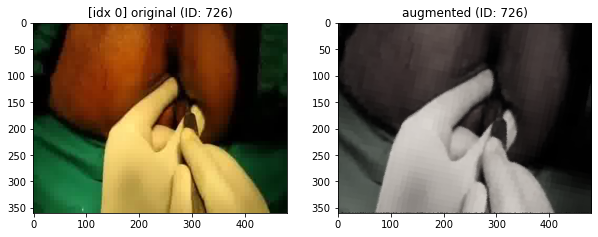

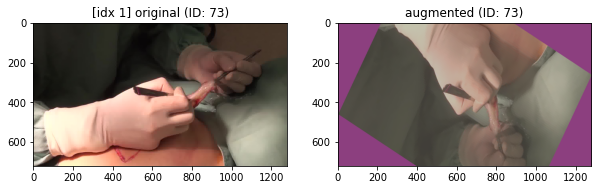

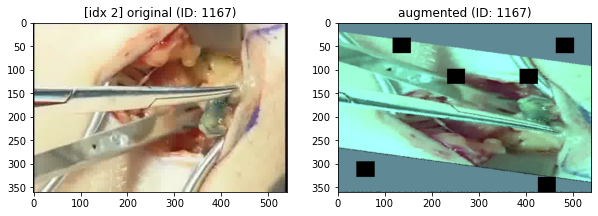

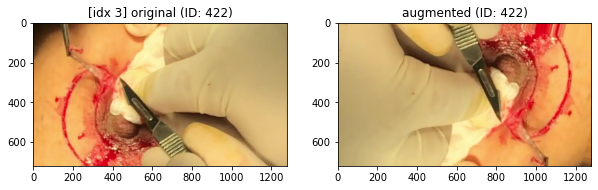

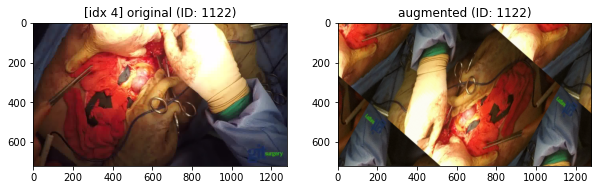

In [11]:

indices = scalpel_indices[3:8] 

pipeline = my_pipeline_v3  

displayScalpelsAugmented(pipeline, indices) 
